In [ ]:
import yfinance as yf
from datetime import datetime

def get_option_chain(ticker, expiration_date):
    stock = yf.Ticker(ticker)
    options_chain = stock.option_chain(expiration_date)
    return options_chain

def get_days_to_expiry(expiration_date):
    expiration_datetime = datetime.strptime(expiration_date, "%Y-%m-%d")
    current_datetime = datetime.now()
    days_to_expiry = (expiration_datetime - current_datetime).days
    return days_to_expiry

def print_option_details(option_chain, expiration_date):
    calls = option_chain.calls
    puts = option_chain.puts

    print(f"----------Options for Expiration Date: {expiration_date}----------")

    print("----------Calls----------")
    for index, call in calls.iterrows():
        days_to_expiry = get_days_to_expiry(expiration_date)
        print(f"Days to Expiry: {days_to_expiry}, Strike: {call['strike']}, Type: Call, Last Trade: {call['lastTradeDate']}, Price: {call['lastPrice']}")

    print("\n----------Puts----------")
    for index, put in puts.iterrows():
        days_to_expiry = get_days_to_expiry(expiration_date)
        print(f"Days to Expiry: {days_to_expiry}, Strike: {put['strike']}, Type: Put, Last Trade: {put['lastTradeDate']}, Price: {put['lastPrice']}")

def main():
    # Ticker de l'action
    ticker = "AAPL"
    # Dates d'expiration des options
    expiration_dates = [
        "2024-04-19", "2024-04-26", "2024-05-03", "2024-05-10", "2024-05-17",
        "2024-05-24", "2024-05-31", "2024-06-21", "2024-07-19", "2024-08-16",
        "2024-09-20", "2024-10-18", "2024-11-15", "2024-12-20", "2025-01-17",
        "2025-03-21", "2025-06-20", "2025-09-19", "2025-12-19", "2026-01-16",
        "2026-06-18", "2026-12-18"
    ]

    for expiration_date in expiration_dates:
        option_chain = get_option_chain(ticker, expiration_date)
        print_option_details(option_chain, expiration_date)
        print("\n")

if __name__ == "__main__":
    main()


----------Options for Expiration Date: 2024-04-19----------
----------Calls----------
Days to Expiry: 3, Strike: 5.0, Type: Call, Last Trade: 2024-04-12 13:51:51+00:00, Price: 173.0
Days to Expiry: 3, Strike: 10.0, Type: Call, Last Trade: 2024-03-27 19:35:59+00:00, Price: 163.0
Days to Expiry: 3, Strike: 15.0, Type: Call, Last Trade: 2024-04-04 14:55:59+00:00, Price: 155.95
Days to Expiry: 3, Strike: 30.0, Type: Call, Last Trade: 2024-03-27 15:14:12+00:00, Price: 142.65
Days to Expiry: 3, Strike: 35.0, Type: Call, Last Trade: 2024-04-12 14:02:42+00:00, Price: 142.43
Days to Expiry: 3, Strike: 40.0, Type: Call, Last Trade: 2024-02-02 16:11:14+00:00, Price: 146.28
Days to Expiry: 3, Strike: 45.0, Type: Call, Last Trade: 2024-04-08 17:09:28+00:00, Price: 123.82
Days to Expiry: 3, Strike: 50.0, Type: Call, Last Trade: 2024-03-05 14:50:15+00:00, Price: 120.68
Days to Expiry: 3, Strike: 55.0, Type: Call, Last Trade: 2024-03-14 17:45:07+00:00, Price: 118.8
Days to Expiry: 3, Strike: 60.0, Typ

In [ ]:
import yfinance as yf
from datetime import datetime
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np
import pandas_market_calendars as mcal

def get_option_chain(ticker, expiration_date):
    stock = yf.Ticker(ticker)
    options_chain = stock.option_chain(expiration_date)
    return options_chain

def get_trading_days_to_expiry(expiration_date):
    nyse = mcal.get_calendar('NYSE')
    expiration_datetime = datetime.strptime(expiration_date, "%Y-%m-%d")
    current_datetime = datetime.now()
    schedule = nyse.schedule(start_date=current_datetime, end_date=expiration_datetime)
    trading_days = nyse.valid_days(schedule.iloc[0]['market_open'], schedule.iloc[-1]['market_close'])
    trading_days_to_expiry = len(trading_days)
    return trading_days_to_expiry

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility(S, K, T, r, price):
    def call_option_implied_volatility(sigma):
        return black_scholes_call(S, K, T, r, sigma) - price
    try:
        implied_vol = brentq(call_option_implied_volatility, 0.01, 10, xtol=1e-6)
        return implied_vol
    except ValueError:
        return np.nan

def print_option_details(option_chain, expiration_date, S, r):
    calls = option_chain.calls

    trading_days_to_expiry = get_trading_days_to_expiry(expiration_date)

    print(f"----------Options for Expiration Date: {expiration_date}----------")

    print("----------Calls----------")
    for index, call in calls.iterrows():
        T = trading_days_to_expiry / 252.0  # 252 jours ouverts dans une année
        K = call['strike']
        price = call['lastPrice']
        implied_vol = implied_volatility(S, K, T, r, price)
        print(f"Trading Days to Expiry: {trading_days_to_expiry}, Strike: {K}, Type: Call, Last Trade: {call['lastTradeDate']}, Price: {price}, Implied Volatility: {implied_vol}")

def main():
    # Ticker de l'action
    ticker = "GOOG"
    # Obtenir les données de l'action
    stock_data = yf.Ticker(ticker)
    # Prix actuel du sous-jacent
    S = stock_data.history(period="1d")["Close"].iloc[-1]
    # Taux sans risque
    r = 0.03
    # Dates d'expiration des options
    expiration_dates = [
        "2024-04-19", "2024-04-26", "2024-05-03", "2024-05-10", "2024-05-17",
        "2024-05-24", "2024-05-31", "2024-07-19",
        "2024-09-20", "2024-10-18", "2024-11-15", "2024-12-20", "2025-01-17",
        "2025-03-21", "2025-06-20", "2025-12-19", "2026-01-16"
    ]

    for expiration_date in expiration_dates:
        option_chain = get_option_chain(ticker, expiration_date)
        print_option_details(option_chain, expiration_date, S, r)
        print("\n")

if __name__ == "__main__":
    main()


----------Options for Expiration Date: 2024-04-19----------
----------Calls----------
Trading Days to Expiry: 5, Strike: 65.0, Type: Call, Last Trade: 2024-04-11 16:12:05+00:00, Price: 94.47, Implied Volatility: nan
Trading Days to Expiry: 5, Strike: 70.0, Type: Call, Last Trade: 2024-03-25 14:36:05+00:00, Price: 80.6, Implied Volatility: nan
Trading Days to Expiry: 5, Strike: 75.0, Type: Call, Last Trade: 2024-03-11 13:36:32+00:00, Price: 63.11, Implied Volatility: nan
Trading Days to Expiry: 5, Strike: 80.0, Type: Call, Last Trade: 2024-04-02 15:23:30+00:00, Price: 74.7, Implied Volatility: nan
Trading Days to Expiry: 5, Strike: 85.0, Type: Call, Last Trade: 2024-04-11 15:07:41+00:00, Price: 73.95, Implied Volatility: nan
Trading Days to Expiry: 5, Strike: 90.0, Type: Call, Last Trade: 2024-04-12 19:45:22+00:00, Price: 69.1, Implied Volatility: nan
Trading Days to Expiry: 5, Strike: 95.0, Type: Call, Last Trade: 2024-04-04 15:48:36+00:00, Price: 60.89, Implied Volatility: nan
Trading

VOLATILITY SMILE

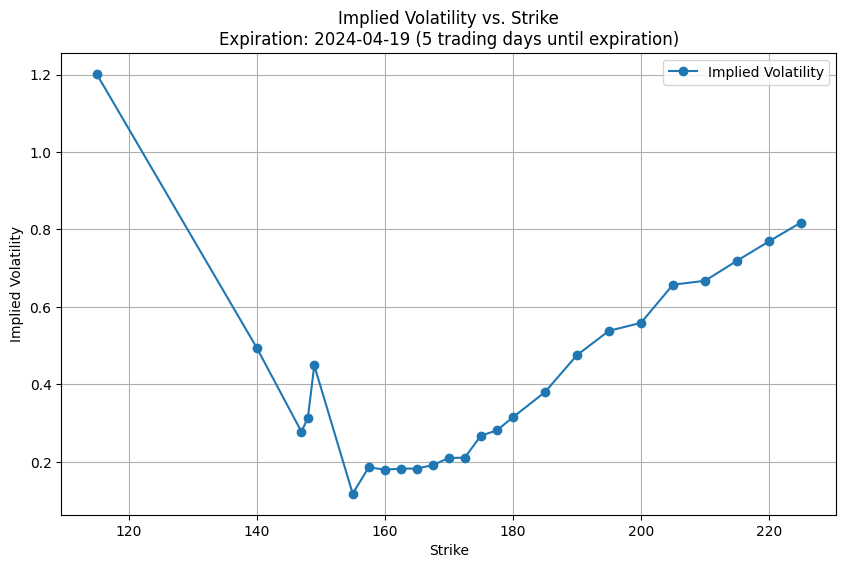

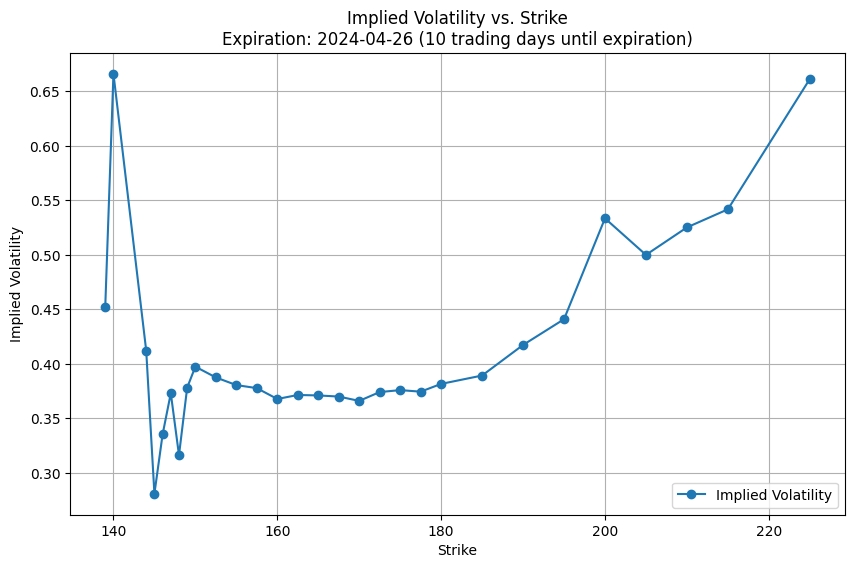

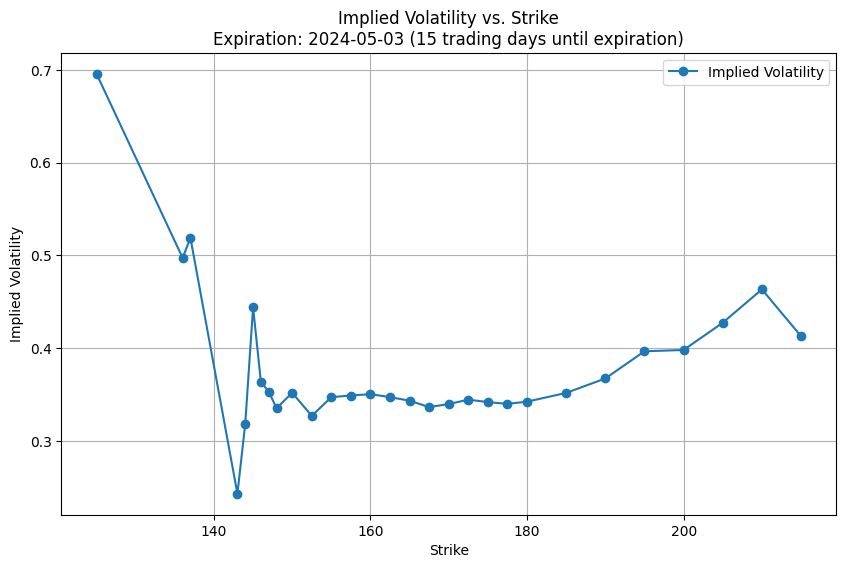

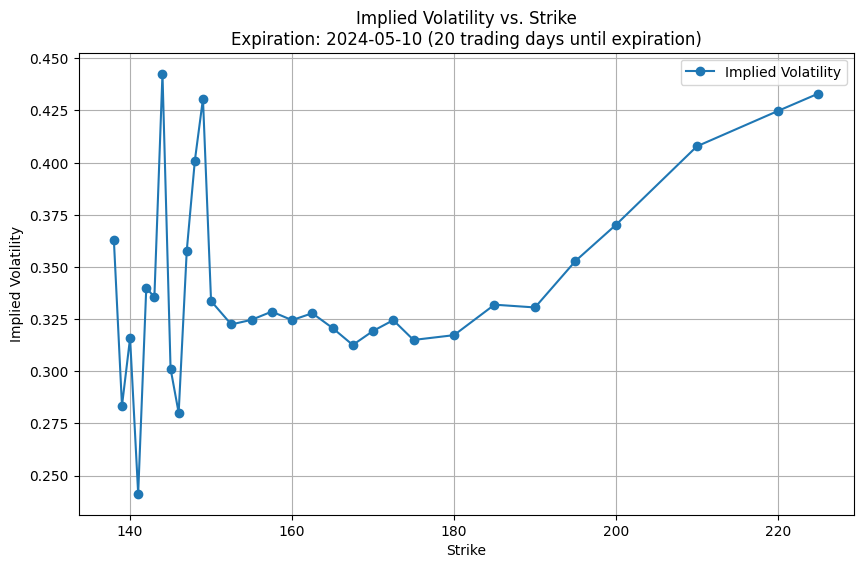

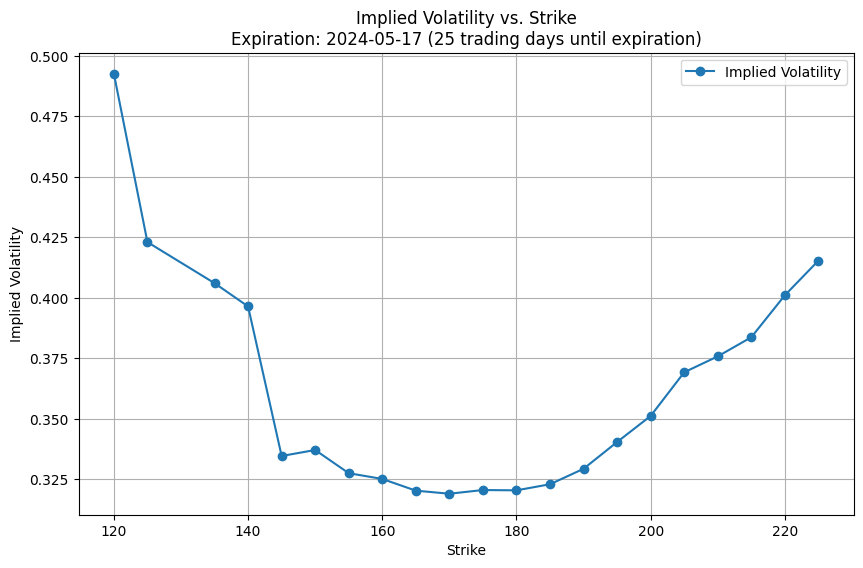

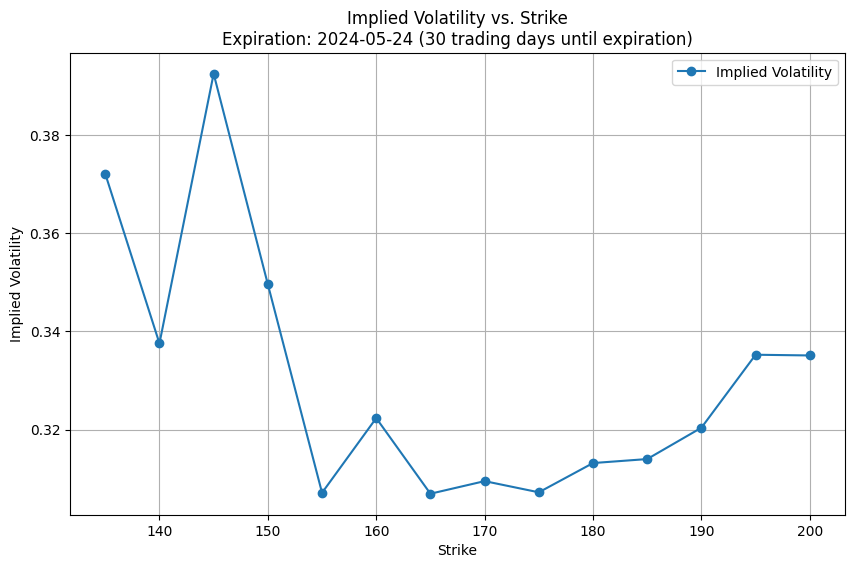

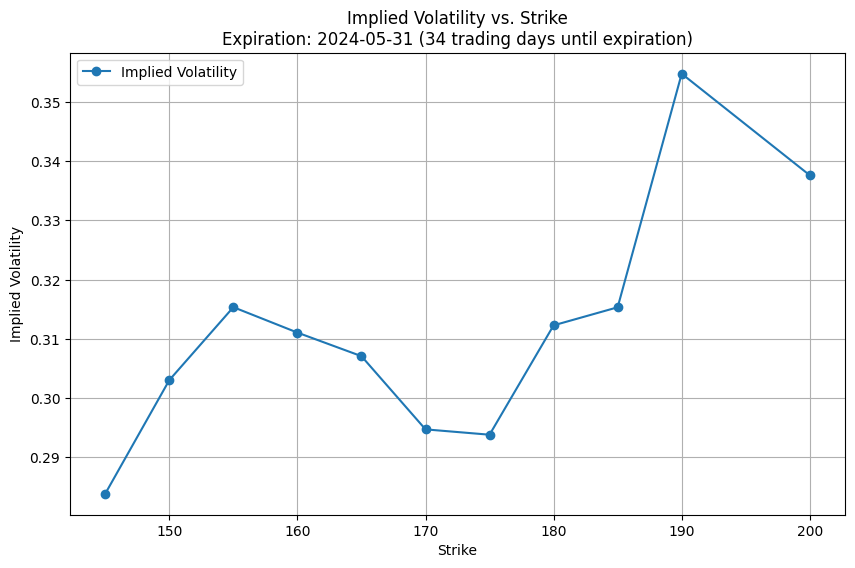

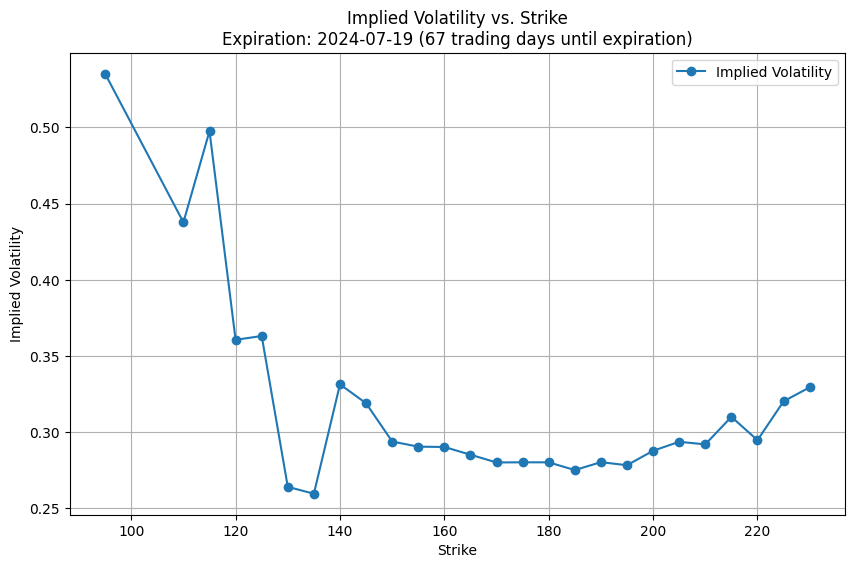

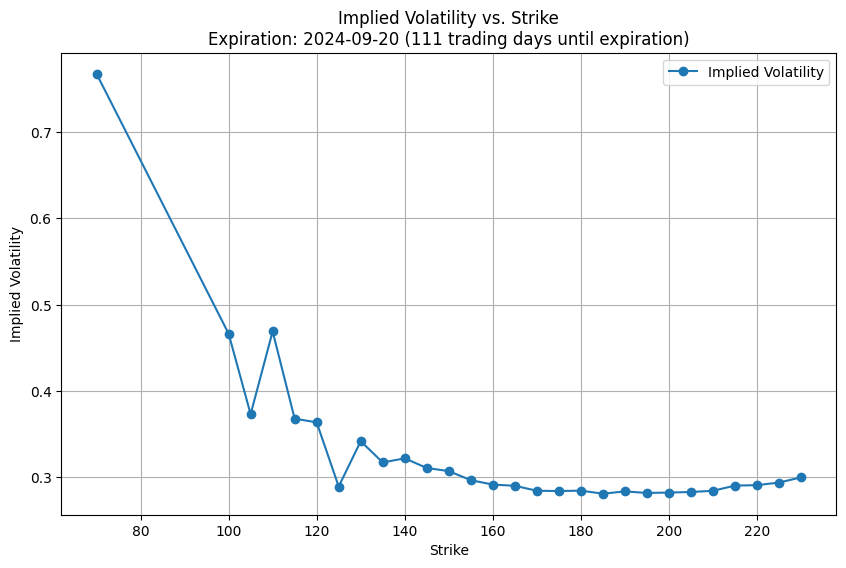

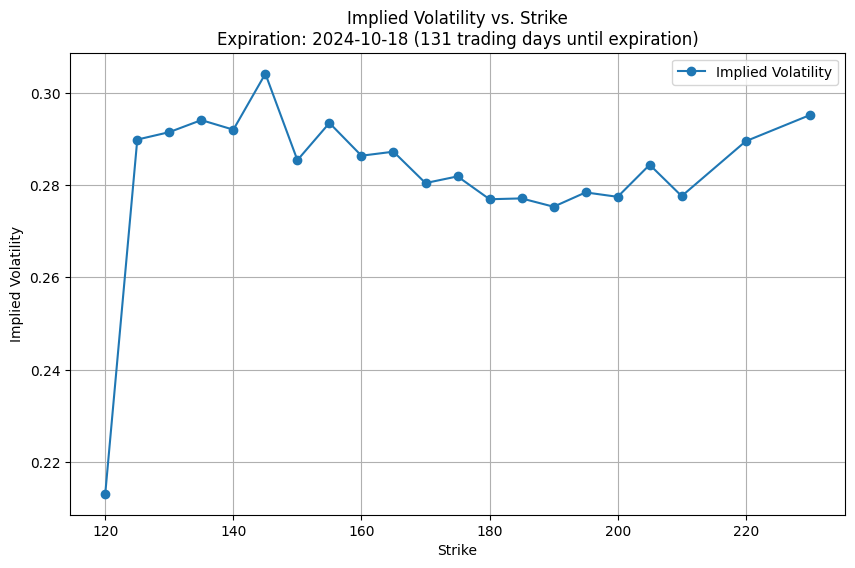

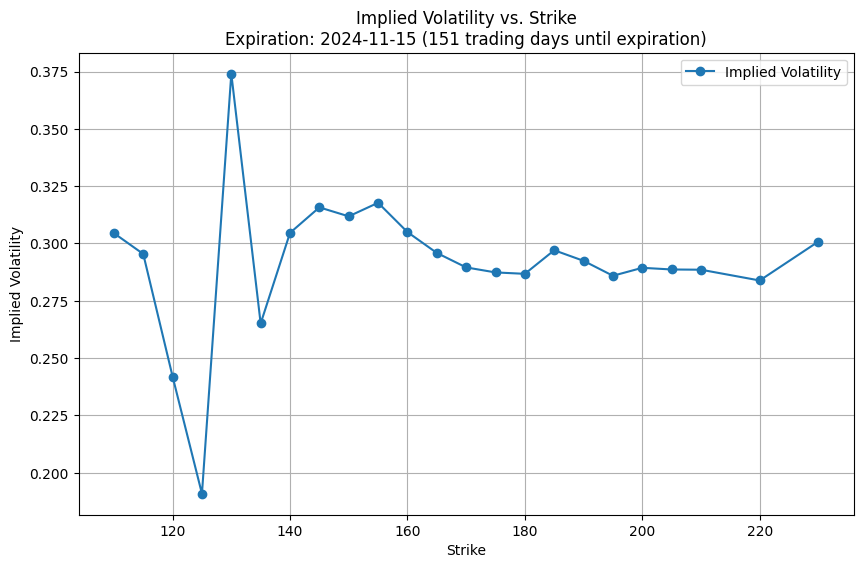

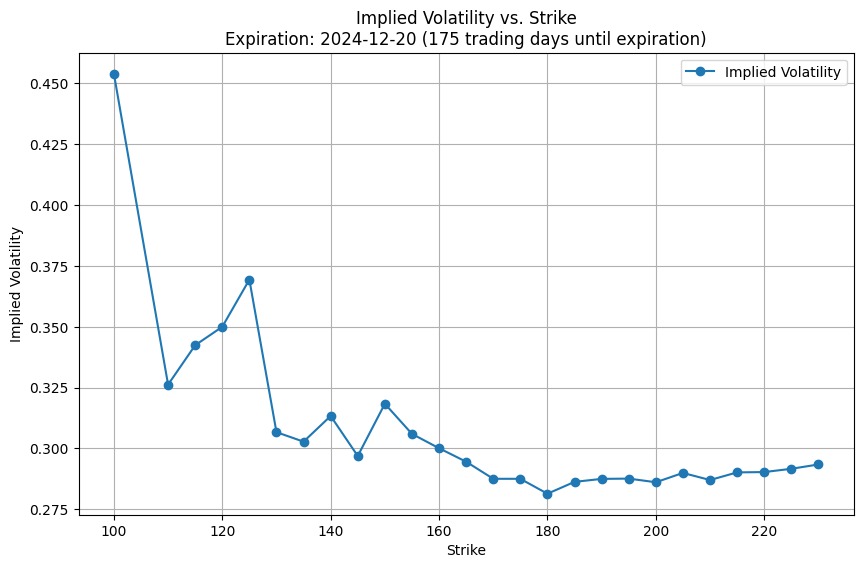

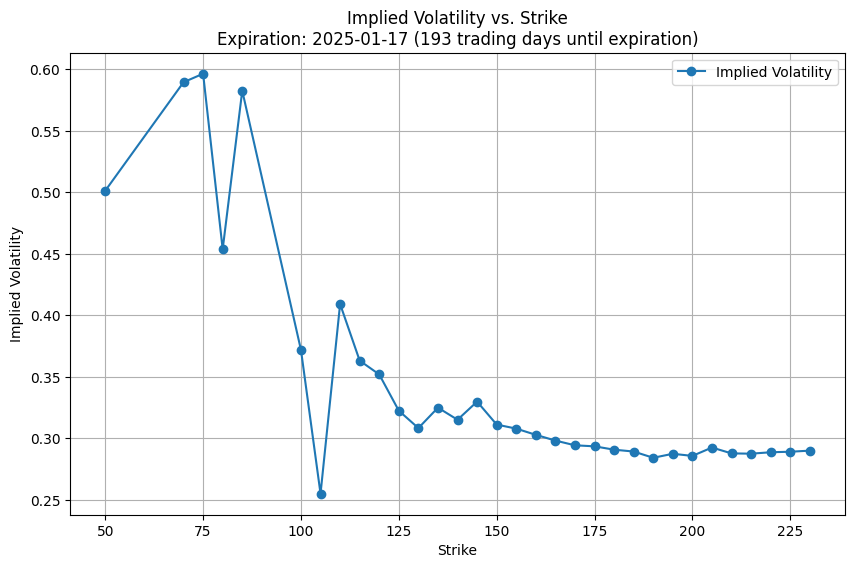

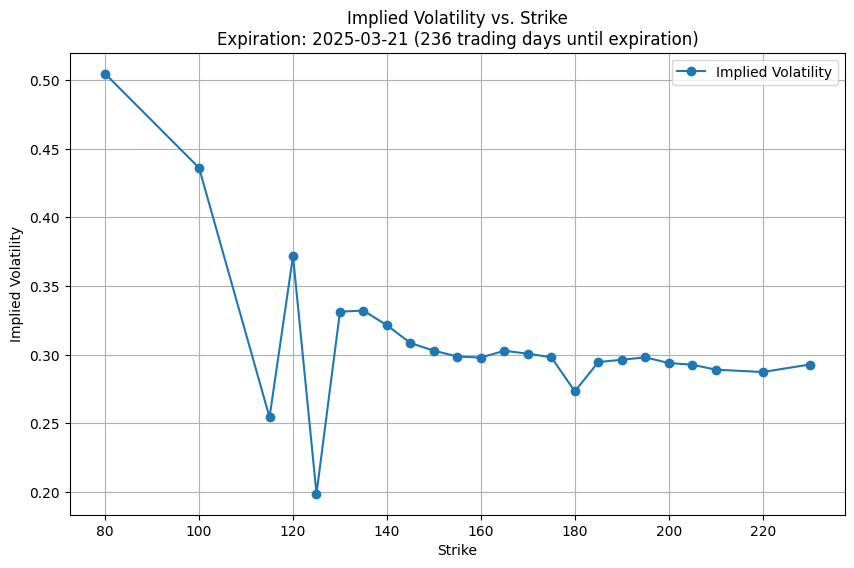

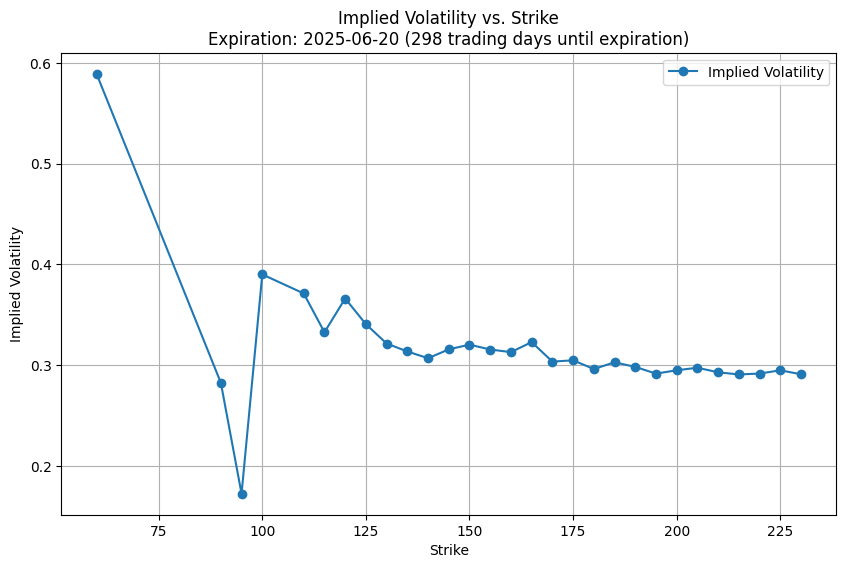

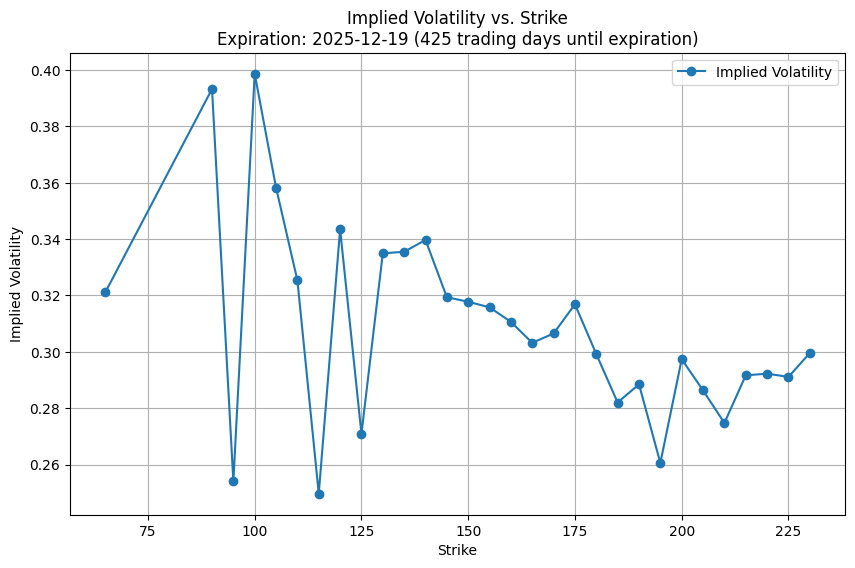

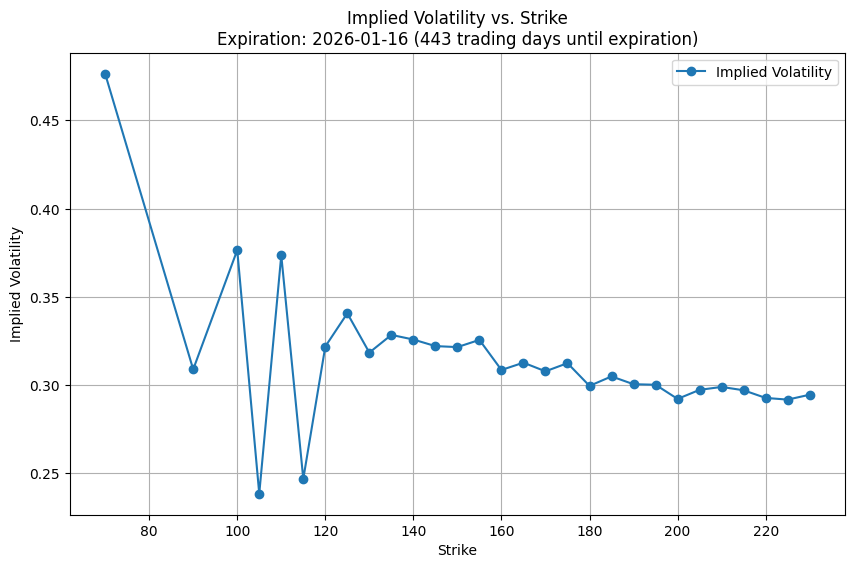

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas_market_calendars as mcal

# Fonction pour calculer le nombre de jours ouverts avant l'expiration
def get_trading_days_to_expiry(expiration_date):
    # Calendrier du marché
    nyse = mcal.get_calendar('NYSE')

    # Convertir la date d'expiration en objet datetime
    expiration_datetime = datetime.datetime.strptime(expiration_date, "%Y-%m-%d")

    # Date actuelle
    current_datetime = datetime.datetime.now()

    # Obtenir les jours ouverts entre aujourd'hui et la date d'expiration
    schedule = nyse.schedule(start_date=current_datetime, end_date=expiration_datetime)
    trading_days = nyse.valid_days(schedule.iloc[0]['market_open'], schedule.iloc[-1]['market_close'])

    # Nombre de jours ouverts restants
    trading_days_to_expiry = len(trading_days)

    return trading_days_to_expiry

def plot_implied_volatility(option_chain, expiration_date, S, r):
    calls = option_chain.calls

    strikes = []
    implied_vols = []
    prices = []

    # Nombre de jours ouverts restants avant expiration
    trading_days_to_expiry = get_trading_days_to_expiry(expiration_date)

    for index, call in calls.iterrows():
        T = trading_days_to_expiry / 252.0  # 252 jours ouverts dans une année
        K = call['strike']
        price = call['lastPrice']
        implied_vol = implied_volatility(S, K, T, r, price)
        if not np.isnan(implied_vol):
            strikes.append(K)
            implied_vols.append(implied_vol)
            prices.append(price)

    plt.figure(figsize=(10, 6))
    plt.plot(strikes, implied_vols, label='Implied Volatility', marker='o', linestyle='-')
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.title(f'Implied Volatility vs. Strike\nExpiration: {expiration_date} ({trading_days_to_expiry} trading days until expiration)')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Ticker de l'action
    ticker = "GOOG"
    # Obtenir les données de l'action
    stock_data = yf.Ticker(ticker)
    # Prix actuel du sous-jacent
    S = stock_data.history(period="1d")["Close"].iloc[-1]
    # Taux sans risque
    r = 0.045
    # Dates d'expiration des options
    expiration_dates = [
        "2024-04-19", "2024-04-26", "2024-05-03", "2024-05-10", "2024-05-17",
        "2024-05-24", "2024-05-31", "2024-07-19",
        "2024-09-20", "2024-10-18", "2024-11-15", "2024-12-20", "2025-01-17",
        "2025-03-21", "2025-06-20", "2025-12-19", "2026-01-16"
    ]

    for expiration_date in expiration_dates:
        option_chain = get_option_chain(ticker, expiration_date)
        plot_implied_volatility(option_chain, expiration_date, S, r)

if __name__ == "__main__":
    main()


EXPECTED VOLATILITY OVER 2 YEARS

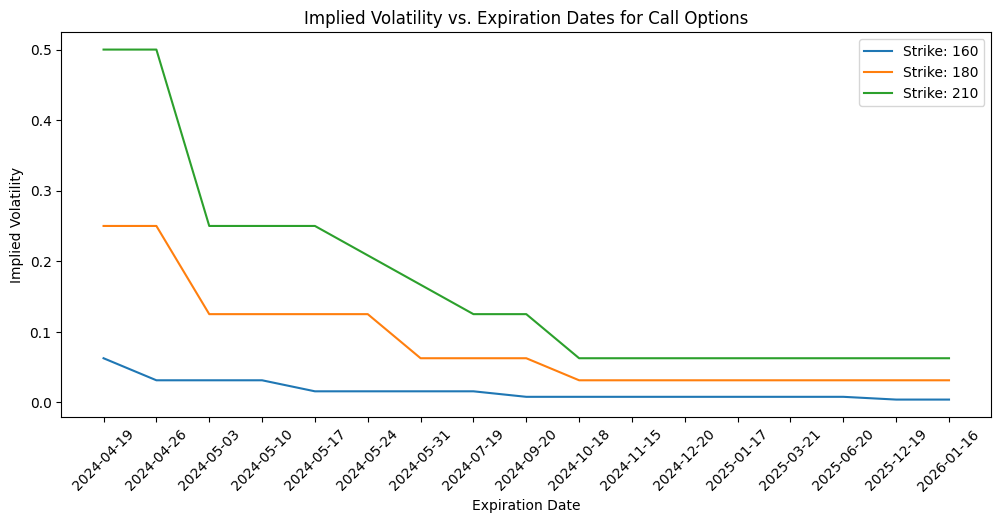

In [11]:
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt

def get_option_chain(ticker, expiration_date):
    stock = yf.Ticker(ticker)
    options_chain = stock.option_chain(expiration_date)
    return options_chain

def plot_iv_vs_expiry_dates(ticker, expiration_dates, strikes):
    plt.figure(figsize=(12, 5))  # Définir la taille du graphique

    for strike in strikes:
        iv_data = {'Expiration Date': [], 'Implied Volatility': []}

        for expiration_date in expiration_dates:
            option_chain = get_option_chain(ticker, expiration_date)
            calls = option_chain.calls

            call_iv = calls[calls['strike'] == strike]['impliedVolatility'].values

            if len(call_iv) > 0:
                iv_data['Expiration Date'].append(expiration_date)
                iv_data['Implied Volatility'].append(call_iv[0])

        plt.plot(iv_data['Expiration Date'], iv_data['Implied Volatility'], label=f'Strike: {strike}')

    plt.xlabel('Expiration Date')
    plt.ylabel('Implied Volatility')
    plt.title('Implied Volatility vs. Expiration Dates for Call Options')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

def main():
    # Ticker de l'action
    ticker = "GOOG"
    # Dates d'expiration des options
    expiration_dates = [
        "2024-04-19", "2024-04-26", "2024-05-03", "2024-05-10", "2024-05-17",
        "2024-05-24", "2024-05-31", "2024-07-19",
        "2024-09-20", "2024-10-18", "2024-11-15", "2024-12-20", "2025-01-17",
        "2025-03-21", "2025-06-20", "2025-12-19", "2026-01-16"
    ]

    # Strikes à tracer
    strikes = [160, 180, 210]

    plot_iv_vs_expiry_dates(ticker, expiration_dates, strikes)

if __name__ == "__main__":
    main()
